<a href="https://colab.research.google.com/github/mohammad-rahbari/federated-learning_visual-classification/blob/main/notebooks/Federated_learning_server_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and data

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import torch
import torchvision

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from torchvision.datasets import CIFAR100
from torch.utils.data import Subset
import numpy as np
import copy
import random
import torch
import pandas as pd

In [7]:
#@title In this block we import the test set of CIFAR100 to evaluate the global model
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 169M/169M [00:03<00:00, 49.6MB/s]


# Collecting data of models we want to aggregate

In [8]:
initial_model_name = "fa4e78ad-aca5-491e-8d8c-9e366f73a708" #@param{"type":"string"}


In [9]:
#@title Client's log file has been loaded in this block so we can use it in next steps
clients_data = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/client_log.csv")
# clients_data.head()

In [10]:
#@title gets the clients
filter =  clients_data['initial_model_name']== initial_model_name
filtered_clients_data = clients_data[filter] # Using filter to collect clients with specified initial model
params = filtered_clients_data[['backbone',
                                    'num_of_clients',
                                    'splitting_method',
                                    'size_of_dataset']]
params = dict(params.iloc[0])
print("Number of all trained clients:", len(clients_data))
print("Number of clients after filtering:", len(filtered_clients_data))
contributors = [] # contributors is being used to store the name of models which contributes in aggregation
for i  in filtered_clients_data['model_name'].values:
  contributors.append(i)
print("Contributors:", contributors)
# filtered_clients_data.head()

Number of all trained clients: 612
Number of clients after filtering: 12
Contributors: ['27de6708-9c4b-4437-9686-ddf6c142dcd9', '9aa489d0-e863-4f3e-b59c-23a63e87f7cf', '4f1f1327-618d-4033-98c2-0ec6ae9e45b9', 'f2ae8f84-e3a7-48f6-8b1a-d6fa41963462', 'aeb02e68-7bc7-473e-b8fc-54fb7fd0541b', 'a075266e-b771-4e71-a900-df6584938565', 'af443160-bb38-4a36-9304-f1c5a10d2aa1', '1f36c48b-d05d-4e2b-a8d8-f91b3edc9c4d', '805819c8-56c6-4b1b-9227-c95ac99b7c99', 'c4ffe955-a431-477a-8ab0-e80f1f73f74f', '7645e3f4-3295-404e-8675-efb098baa197', '32a612ba-d8d2-4508-be26-ae9f0defd752']


In [11]:
#@title Dino Model
import torch
import torch.nn as nn

class DinoClassifier(nn.Module):
  def __init__(self, backbone, num_classes:int=100, device=None):
    super(DinoClassifier, self).__init__()
    self.backbone = torch.hub.load('facebookresearch/dino:main', backbone)


    #We need to freaze thhe parameters of bakbone first so we can train only on the head layer(output layer)
    for param in self.backbone.parameters():
      param.requires_grad = False

    #determine the Device
    if device is None:
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.backbone.to(device)

    #To detect the output feature dimontion of backbone we run  Dummy forward pass
    with torch.no_grad():

      dummy_input = torch.randn(1,3,224,224).to(device)
      dummy_out = self.backbone(dummy_input)


      if isinstance(dummy_out, tuple):
        dummy_out = dummy_out[0]
      elif isinstance(dummy_out, dict):
        dummy_out = dummy_out.get("x_norm_clstoken", next(iter(dummy_out.values())))

      #If the output is 3D (B, T, D), we assume first token is the [CLS] token.
      if dummy_out.dim() == 3:
        dummy_feature = dummy_out[:,0]
      else:
        dummy_feature = dummy_out
      feature_dim = dummy_feature.shape[1]
      print("Detected feature dimontion:", feature_dim)


      #Hidden Layer
      self.hidden = nn.Sequential(
          nn.Linear(feature_dim, 128),
          nn.ReLU()
      )


      #Difineing the classification Head
      self.head = nn.Linear(128, num_classes)

      #Ensure the head is trainable.
      for param in self.hidden.parameters():
        param.requires_grad = True
      for param in self.head.parameters():
        param.requires_grad = True

  def forward(self,x):

    #pass the input through the backbone
    features = self.backbone(x)

    if isinstance(features, tuple):
      features = features[0]
    elif isinstance(features, dict):
      features = features.get("x_norm_clstoken", next(iter(features.values())))


    # If featers are retuened as (B, T, D), use the first token
    if features.dim() == 3:
      features = features[:,0]


    hidden_out  = self.hidden(features)

    logits = self.head(hidden_out)

    return logits


In [12]:
# @title `get_model` function retrieves and loads the models of filtered clients
def get_model(paths,criterion, backbone):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = DinoClassifier(backbone=backbone, num_classes=100, device=device) # Loading an initial custom dino model
  for index in range(len(paths)):
    state_dict = torch.load(paths.iloc[index]) # load state dict regarding the client number 'index'
    model.head.load_state_dict(state_dict["head"]) # set the state dict based on client
    model.hidden.load_state_dict(state_dict["hidden"]) # set the state dict based on client

    model.to(device)
    yield (model,criterion.iloc[index]) # this command throws model one at the time so less time and resouces will be used



# Aggregation functions

Implemented algorithm:

*   FedAvg
*   FedAvgM
*   EMA
*   FedQ



In [13]:
#@title <h2>FebAvg</h2>
def feb_avg(df):
  total_samples = df["client_train_size"].sum() # Calculate the total number of samples of clients wich had contributed
  global_weights = {"head":None, "hidden":None} # This variable stores the weights we want to modify

  models = get_model(df["path"],df["client_train_size"], df.iloc[0]["backbone"])
  with torch.no_grad():

    for model, sample_size in models:
      if global_weights["head"] is None:
        global_weights["head"] = copy.deepcopy(model.head.state_dict())
        global_weights["hidden"] = copy.deepcopy(model.hidden.state_dict())
        global_model = copy.deepcopy(model)
        for k in global_weights["head"].keys():
          global_weights["head"][k].zero_() # This command sets the tensor to zero
        for k in global_weights["hidden"].keys():
          global_weights["hidden"][k].zero_() # This command sets the tensor to zero

      for k in global_weights["head"].keys():
        global_weights["head"][k] += model.head.state_dict()[k] * (sample_size / total_samples) # Each weight will be assgin by average of all clients weights
      for k in global_weights["hidden"].keys():
        global_weights["hidden"][k] += model.hidden.state_dict()[k] * (sample_size / total_samples) # Each weight will be assgin by average of all clients weights
    global_model.head.load_state_dict(global_weights["head"]) # A model with modified head will be assignd
    global_model.hidden.load_state_dict(global_weights["hidden"]) # A model with modified hidden will be assignd
  return global_model



In [14]:
#@title FebAvgM
def feb_avg_m(df, momentum_coefficient=0.9, momentum_vector_path= None):

  total_samples = df["client_train_size"].sum() # Calculate the total number of samples of clients wich had contributed
  delta = {"head":None, "hidden":None} # `delta` is variable that keep the average of clients
  global_weights = {"head":None, "hidden":None} # This variable stores the weights we want to modify

  models = get_model(df["path"],df["client_train_size"], df.iloc[0]["backbone"])
  with torch.no_grad():

    for model, sample_size in models:
      if delta['head'] is None:

        global_model = copy.deepcopy(model)
        global_weights["head"] = copy.deepcopy(model.head.state_dict())
        global_weights["hidden"] = copy.deepcopy(model.hidden.state_dict())
        delta["head"] = { k: torch.zeros_like(v) for k, v in global_weights["head"].items() } # A dict with structure of the model that we want to modify will be generated
        delta["hidden"] = { k: torch.zeros_like(v) for k, v in global_weights["hidden"].items() } # A dict with structure of the model that we want to modify will be generated


      client_head = model.head.state_dict()
      for k in delta['head'].keys():
        delta['head'][k] += (client_head[k] - global_weights["head"][k]) * (sample_size / total_samples) # Each weight will be assgin by average of all clients weights

      client_hidden = model.hidden.state_dict()
      for k in delta['hidden'].keys():
        delta['hidden'][k] += (client_hidden[k] - global_weights["hidden"][k]) * (sample_size / total_samples) # Each weight

    # In this section we calculate the momentum_vector


    if momentum_vector_path is None:
      momentum_vector = {
          "head": {k: delta["head"][k].clone() for k in delta["head"]},
          "hidden": {k: delta["hidden"][k].clone() for k in delta["hidden"]}
      }
    else:
      momentum_vector = torch.load(momentum_vector_path) #In rounds > 1 momentum vector is requerd to be loaded from drive
      for k in delta['head'].keys():
        momentum_vector['head'][k] = momentum_coefficient * momentum_vector['head'][k]  + delta['head'][k]  # Using the the formula of FebAvgM we calculate the momentum vector
      for k in delta['hidden'].keys():
        momentum_vector['hidden'][k] = momentum_coefficient * momentum_vector['hidden'][k]  + delta['hidden'][k]  # Using the the formula of FebAvgM we calculate the momentum vector






    global_head = copy.deepcopy(global_model.head.state_dict())
    for k in momentum_vector['head'].keys():
      global_head[k] =global_head[k] + momentum_vector['head'][k] #After adding momentum vector the last global model we use clamp function we insure to keep momentum vector in boundary
    global_hidden = copy.deepcopy(global_model.hidden.state_dict())
    for k in momentum_vector['hidden'].keys():
      global_hidden[k] = global_hidden[k] + momentum_vector['hidden'][k]#After adding momentum vector the last global model we use clamp function


    global_model.head.load_state_dict(global_head)
    global_model.hidden.load_state_dict(global_hidden)


  return global_model, momentum_vector # We return momentum_vector to save it and use for next aggregation steps



In [15]:
#@title EMA
def EMA(df, decay=0.9, momentum_vector_path= None):

  total_samples = df["client_train_size"].sum() # Calculate the total number of samples of clients wich had contributed
  delta = {"head":None, "hidden":None} # `delta` is variable that keep the average of clients
  global_weights = {"head":None, "hidden":None} # This variable stores the weights we want to modify

  models = get_model(df["path"],df["client_train_size"], df.iloc[0]["backbone"])
  with torch.no_grad():

    for model, sample_size in models:
      if delta['head'] is None:

        global_model = copy.deepcopy(model)
        global_weights["head"] = copy.deepcopy(model.head.state_dict())
        global_weights["hidden"] = copy.deepcopy(model.hidden.state_dict())
        delta["head"] = { k: torch.zeros_like(v) for k, v in global_weights["head"].items() } # A dict with structure of the model that we want to modify will be generated
        delta["hidden"] = { k: torch.zeros_like(v) for k, v in global_weights["hidden"].items() } # A dict with structure of the model that we want to modify will be generated


      client_head = model.head.state_dict()
      for k in delta['head'].keys():
        delta['head'][k] += (client_head[k] - global_weights["head"][k]) * (sample_size / total_samples) # Each weight will be assgin by average of all clients weights

      client_hidden = model.hidden.state_dict()
      for k in delta['hidden'].keys():
        delta['hidden'][k] += (client_hidden[k] - global_weights["hidden"][k]) * (sample_size / total_samples) # Each weight

    # In this section we calculate the momentum_vector


    if momentum_vector_path is None:
      momentum_vector = {
          "head": {k: delta["head"][k].clone() for k in delta["head"]},
          "hidden": {k: delta["hidden"][k].clone() for k in delta["hidden"]}
      }
    else:
      momentum_vector = torch.load(momentum_vector_path) #In rounds > 1 momentum vector is requerd to be loaded from drive
      for k in delta['head'].keys():

        momentum_vector['head'][k] = decay * momentum_vector['head'][k]  + (1- decay) *  delta['head'][k]  # Using the the formula of EMA we calculate the momentum vector
      for k in delta['hidden'].keys():
        momentum_vector['hidden'][k] = decay * momentum_vector['hidden'][k]  + (1- decay) *  delta['hidden'][k]  # Using the the formula of FebAvgM we calculate the momentum vector






    global_head = copy.deepcopy(global_model.head.state_dict())
    for k in momentum_vector['head'].keys():
      global_head[k] =global_head[k] + momentum_vector['head'][k] #After adding momentum vector the last global model we use clamp function we insure to keep momentum vector in boundary
    global_hidden = copy.deepcopy(global_model.hidden.state_dict())
    for k in momentum_vector['hidden'].keys():
      global_hidden[k] = global_hidden[k] + momentum_vector['hidden'][k]#After adding momentum vector the last global model we use clamp function


    global_model.head.load_state_dict(global_head)
    global_model.hidden.load_state_dict(global_hidden)


  return global_model, momentum_vector # We return momentum_vector to save it and use for next aggregation steps




In [16]:
#@title FedQ
def minmax(series):
    min_val, max_val = series.min(), series.max()
    if min_val == max_val:
        return pd.Series([1.0] * len(series), index=series.index)
    return (series - min_val) / (max_val - min_val)

def FedQ(df, decay=0.9, momentum_vector_path= None):
  alpha = 0.5
  df["sample_size_scaled"] = minmax(df["client_train_size"])
  df["acc_scaled"] = minmax(df["accuracy"])

  df["avg_criterion"] = alpha * df["acc_scaled"] + (1 - alpha) * df["sample_size_scaled"]

  total_sum = df["avg_criterion"].sum()

  delta = {"head":None, "hidden":None} # `delta` is variable that keep the average of clients
  global_weights = {"head":None, "hidden":None} # This variable stores the weights we want to modify

  models = get_model(df["path"], df["avg_criterion"], df.iloc[0]["backbone"])
  with torch.no_grad():

    for model, avg_criterion in models:
      if delta['head'] is None:

        global_model = copy.deepcopy(model)
        global_weights["head"] = copy.deepcopy(model.head.state_dict())
        global_weights["hidden"] = copy.deepcopy(model.hidden.state_dict())
        delta["head"] = { k: torch.zeros_like(v) for k, v in global_weights["head"].items() } # A dict with structure of the model that we want to modify will be generated
        delta["hidden"] = { k: torch.zeros_like(v) for k, v in global_weights["hidden"].items() } # A dict with structure of the model that we want to modify will be generated


      client_head = model.head.state_dict()
      for k in delta['head'].keys():
        delta['head'][k] += (client_head[k] - global_weights["head"][k]) * (avg_criterion / total_sum) # Each weight will be assgin by average of all clients weights

      client_hidden = model.hidden.state_dict()
      for k in delta['hidden'].keys():
        delta['hidden'][k] += (client_hidden[k] - global_weights["hidden"][k]) * (avg_criterion / total_sum) # Each weight

    # In this section we calculate the momentum_vector


    if momentum_vector_path is None:
      momentum_vector = {
          "head": {k: delta["head"][k].clone() for k in delta["head"]},
          "hidden": {k: delta["hidden"][k].clone() for k in delta["hidden"]}
      }
    else:
      momentum_vector = torch.load(momentum_vector_path) #In rounds > 1 momentum vector is requerd to be loaded from drive
      for k in delta['head'].keys():

        momentum_vector['head'][k] = decay * momentum_vector['head'][k]  + (1- decay) *  delta['head'][k]  # Using the the formula of EMA we calculate the momentum vector
      for k in delta['hidden'].keys():
        momentum_vector['hidden'][k] = decay * momentum_vector['hidden'][k]  + (1- decay) *  delta['hidden'][k]  # Using the the formula of FebAvgM we calculate the momentum vector






    global_head = copy.deepcopy(global_model.head.state_dict())
    for k in momentum_vector['head'].keys():
      global_head[k] =global_head[k] + momentum_vector['head'][k] #After adding momentum vector the last global model we use clamp function we insure to keep momentum vector in boundary
    global_hidden = copy.deepcopy(global_model.hidden.state_dict())
    for k in momentum_vector['hidden'].keys():
      global_hidden[k] = global_hidden[k] + momentum_vector['hidden'][k]#After adding momentum vector the last global model we use clamp function


    global_model.head.load_state_dict(global_head)
    global_model.hidden.load_state_dict(global_hidden)


  return global_model, momentum_vector # We return momentum_vector to save it and use for next aggregation steps




In [17]:
# @title This function will evaluate the model.</br> The outputs are loss and accuracy
def evaluation(model, data_loader):
  criterion = nn.CrossEntropyLoss()
  model.eval()
  correct = 0
  total = 0
  test_loss = 0

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  with torch.no_grad():
    for images, labels in  data_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)

      _, prediction = torch.max(outputs.data,1)
      loss = criterion(outputs, labels)
      test_loss += loss.item() * labels.size(0)

      total += labels.size(0)
      correct += (prediction == labels).sum().item()
    accuracy = 100 * correct / total
    loss = test_loss / total
    return accuracy, loss



In [18]:
# @title <h2>`next_id`</h2> This function generates a unique name for model. `uuid4` does not generate duplicated but we are using a fixed `seed` hence we insure this name does not already exists.

from uuid import uuid4
import os
def next_id(log_path):
  if os.path.exists(log_path):
    df = pd.read_csv(log_path)
    while True:
      uuid = str(uuid4())
      if uuid not in df["model_name"].values:
        return uuid
  else:
    return str(uuid4())

In [19]:
#@title _
from datetime import datetime

def get_current_time():
  now = datetime.now()

  formatted_date_time = now.strftime("%Y-%m-%d %H:%M:%S") # Format the date and time as a string

  return formatted_date_time

def global_model_name_path_generator():

  model_name = next_id("/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_log.csv")

  path = "/content/drive/MyDrive/MLDL_FederatedLearning/models/global/" + model_name + ".pth"

  return model_name, path



In [20]:
#@title delete model
import os
import pandas as pd
import numpy as np
def del_model(model_name):
  log_df = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_log.csv")
  filter = log_df["model_name"] == model_name
  if not filter.any():
    print(f"recored ({model_name}) not found.")
    return
  if os.path.exists(log_df[filter]["path"].values[0]):
    os.remove(log_df[filter]["path"].values[0])
  else:
    print("model not found")


  try:
    os.remove(log_df[filter]["momentum_vector_path"].values[0])
  except:
    print("momentum vector not found")
  log_df = log_df[~filter]
  log_df.to_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_log.csv", index=False)
# del_model("e3435947-ad6e-4ca2-8408-390021b33a18")

In [21]:
#@title use this block to modify the global log file
# temp = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_log.csv")
# temp["aggregation_method"] =[ np.nan] * len(temp)
# temp["contributors"] =[ np.nan] * len(temp)
# temp["momentum_vector_path"] = [np.nan] * len(temp)

# temp = temp[['backbone',
#               'num_of_clients',
#               'splitting_method',
#               'aggregation_method',
#               'Measurement_criteria',
#               'accuracy',
#               'loss',
#               'size_of_dataset',
#               'train_test_ratio',
#               'classes',
#               'round_number',
#               'num_of_participants',
#               'model_name',
#               'prev_global_model_name',
#               "contributors",
#               'path',
#               "momentum_vector_path",
#               'path_to_subsets',
#               'path_to_class_combs',
#               'time'
#                ]]
# temp.to_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_log.csv", index=False)
# temp.head()
# del temp

In [22]:
#@title <h1>Select aggregation method </h1>
#@markdown This value will be auto assigned in case the initial model of filtered clients have been aggregated with a spicific aggregation function in the previous rounds

aggregation_method = "FedQ"   #@param["FebAvg","FebAvgM", "EMA","FedQ" ]

prev_agg_method = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_log.csv")

filter = prev_agg_method["model_name"] == initial_model_name
prev_agg_method = prev_agg_method[filter]

prev_agg_method = prev_agg_method["aggregation_method"].values[0]

aggregation_method = aggregation_method if not type(prev_agg_method) == type("str") else prev_agg_method


print(f"{aggregation_method} has been selected as the Aggregation function.")

FedQ has been selected as the Aggregation function.


In [23]:
#@title Aggregation
if aggregation_method == "FebAvg":
  global_model = feb_avg(filtered_clients_data)
elif aggregation_method == "FebAvgM":
  global_model,momentum_vector = feb_avg_m(filtered_clients_data)
elif aggregation_method == "EMA":
  global_model,momentum_vector = EMA(filtered_clients_data)
elif aggregation_method == "FedQ":
  global_model,momentum_vector = FedQ(filtered_clients_data)
else:
  print("Invalid aggregation method")


model_name, path = global_model_name_path_generator()

test_accracy, test_loss= evaluation(global_model, test_loader)
print(f"Accurace:{test_accracy:.2f}")
print(f"Loss:{test_loss:.2f}")

/tmp/ipython-input-16-690545916.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sample_size_scaled"] = minmax(df["client_train_size"])
/tmp/ipython-input-16-690545916.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["acc_scaled"] = minmax(df["accuracy"])
/tmp/ipython-input-16-690545916.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

Detected feature dimontion: 384
Accurace:11.27
Loss:4.16


In [26]:
#@title Saves new generated global model
import os
log_path = "/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_log.csv"

prev_global_model_name = filtered_clients_data["initial_model_name"].values[0]
global_model_log = filtered_clients_data.drop(["client_id","train_loss","client_train_size","client_test_size","duration",],axis=1)
global_model_log = global_model_log.iloc[0]
global_model_log["num_of_participants"] = len(filtered_clients_data)
global_model_log["prev_global_model_name"] = initial_model_name
global_model_log["model_name"]= model_name
global_model_log["accuracy"] = test_accracy
global_model_log["loss"] = test_loss
global_model_log["time"] = get_current_time()
global_model_log["path"] = path
global_model_log["Measurement_criteria"] = "accuracy,loss"
global_model_log["contributors"] = contributors
global_model_log["aggregation_method"] = aggregation_method

if aggregation_method == "FebAvg":
  global_model_log["momentum_vector_path"] = None

elif aggregation_method == "FebAvgM" or aggregation_method == "EMA" or aggregation_method == "FedQ" :
  global_model_log["momentum_vector_path"] = "/content/drive/MyDrive/MLDL_FederatedLearning/models/global/momentun_vectors/MV_"+ model_name + ".pt"
  torch.save(momentum_vector, global_model_log["momentum_vector_path"])


global_model_log = pd.DataFrame(global_model_log).T
global_model_log = global_model_log[['backbone',
              'num_of_clients',
              'splitting_method',
              'aggregation_method',
              'Measurement_criteria',
              'accuracy',
              'loss',
              'size_of_dataset',
              'train_test_ratio',
              'classes',
              'round_number',
              'num_of_participants',
              'model_name',
              'prev_global_model_name',
              "contributors",
              'path',
              "momentum_vector_path",
              'path_to_subsets',
              'path_to_class_combs',
              'time'
               ]]

flag = False
if os.path.exists(path):
  print("Model already exist")
  flag = True

if os.path.exists(log_path):
  global_log_df = pd.read_csv(log_path)
  if model_name in global_log_df["model_name"].values:
    print("record already exist")
    flag = True
  if not flag:
    global_model_log.to_csv(log_path, mode='a', header=False, index=False)
else:
  if not flag:
    global_model_log.to_csv(log_path, index=False, header=True)


if not flag:
  torch.save(global_model.state_dict(),  path )
  if aggregation_method == "FebAvgM" or aggregation_method == "EMA":
    torch.save(momentum_vector, global_model_log["momentum_vector_path"].values[0])


# OUTCOME

In [27]:
global_model_log.head()

,backbone,num_of_clients,splitting_method,aggregation_method,Measurement_criteria,accuracy,loss,size_of_dataset,train_test_ratio,classes,round_number,num_of_participants,model_name,prev_global_model_name,contributors,path,momentum_vector_path,path_to_subsets,path_to_class_combs,time
600,dino_vits16,80,non-i.i.d. sharing,FedQ,"accuracy,loss",11.27,4.15616,50000,"{'train': 0.8, 'test': 0.2}",all,1,12,7b262d43-e7d7-4a3e-9086-75c0bb22eeea,fa4e78ad-aca5-491e-8d8c-9e366f73a708,"[27de6708-9c4b-4437-9686-ddf6c142dcd9, 9aa489d...",/content/drive/MyDrive/MLDL_FederatedLearning/...,/content/drive/MyDrive/MLDL_FederatedLearning/...,/content/drive/MyDrive/MLDL_FederatedLearning/...,/content/drive/MyDrive/MLDL_FederatedLearning/...,2025-07-06 23:24:58


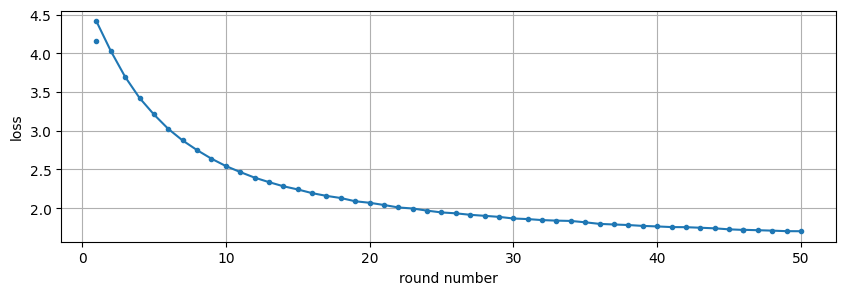

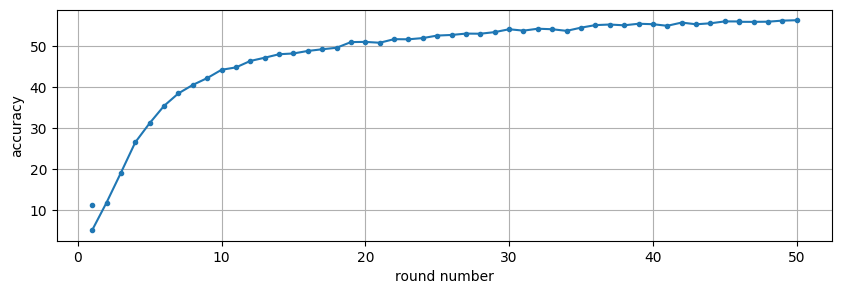

<BarContainer object of 80 artists>

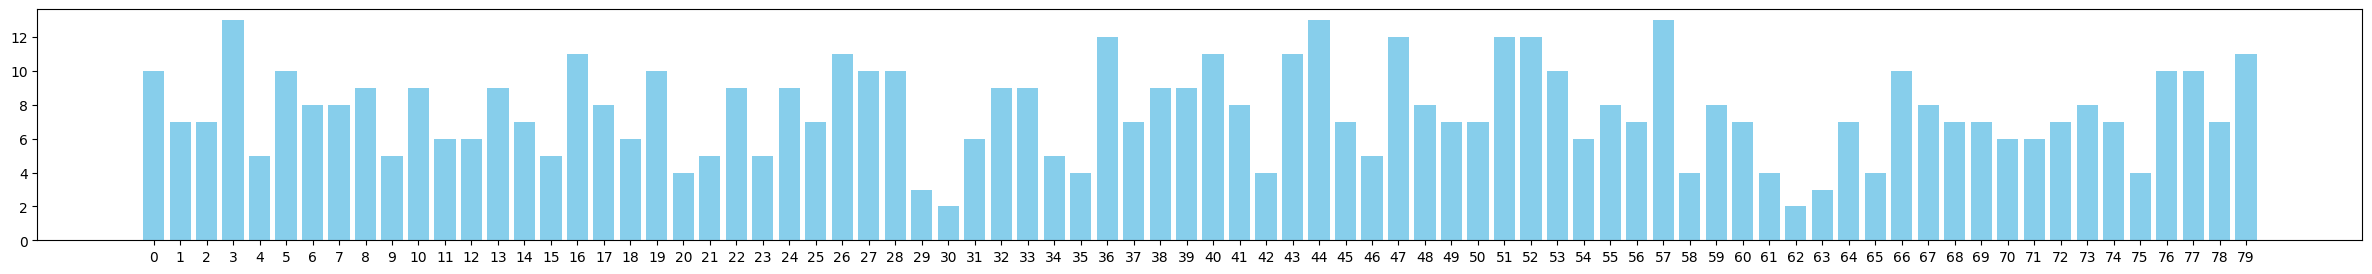

In [28]:
import matplotlib.pyplot as plt


pre_df = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_log.csv")



def my_plot(pre_df,column_name):
  plt.figure(figsize=(10, 3))
  plt.plot( pre_df["round_number"],pre_df[column_name], ".-" )

  plt.grid(True)
  plt.xlabel("round number")
  plt.ylabel(column_name)

  plt.show()
my_plot(pre_df,"loss")
my_plot(pre_df,"accuracy")


client_n_lst= list(clients_data["client_id"].values)
client_n_lst.sort()
client_n_set  = list(set(client_n_lst))
count_lst = []
for i in range(len(client_n_set)):
  count_lst.append(client_n_lst.count(client_n_set[i]))
  client_n_set[i] = str(client_n_set[i])
plt.figure(figsize=(30, 3))
plt.bar(client_n_set,count_lst,color='skyblue')